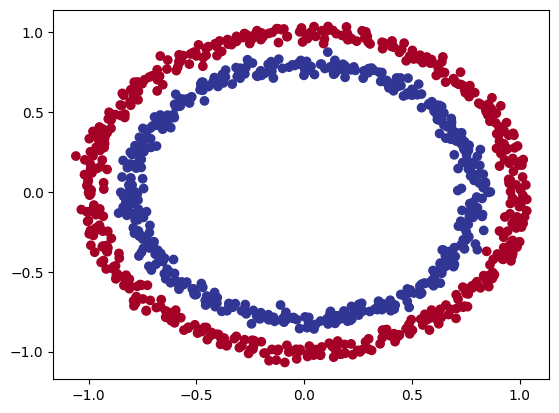

In [49]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [50]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [51]:
circles.label.value_counts()

,count
label,
1,500
0,500


In [52]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one saple of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample}")

Values for one saple of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: 1


In [53]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [54]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [55]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU() # relu is a non-linear activation function

  def forward(self, x):
    # Where should we put our non-linear activation functions?
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = CircleModel().to(device)
model

CircleModel(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [56]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.1)

In [57]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [63]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
  ### Training
  model.train()

  # 1. Forward pass
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> pred probabilities -> pred labels

  # 2. Calculate the loss
  loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss (takes in logis as first input)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_accuracy = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

  # Print out what's happenin'
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}%, | Test loss: {test_loss:.5f}, Test acc: {test_accuracy:.2f}")

Epoch: 0 | Loss: 0.67298, Acc: 59.62%, | Test loss: 0.67067, Test acc: 59.50
Epoch: 100 | Loss: 0.66661, Acc: 61.12%, | Test loss: 0.66544, Test acc: 62.00
Epoch: 200 | Loss: 0.65590, Acc: 64.25%, | Test loss: 0.65707, Test acc: 65.00
Epoch: 300 | Loss: 0.63900, Acc: 67.38%, | Test loss: 0.64342, Test acc: 69.00
Epoch: 400 | Loss: 0.60738, Acc: 74.00%, | Test loss: 0.61813, Test acc: 74.50
Epoch: 500 | Loss: 0.54766, Acc: 90.00%, | Test loss: 0.56643, Test acc: 85.00
Epoch: 600 | Loss: 0.44891, Acc: 96.75%, | Test loss: 0.47628, Test acc: 94.50
Epoch: 700 | Loss: 0.32489, Acc: 99.00%, | Test loss: 0.35721, Test acc: 98.50
Epoch: 800 | Loss: 0.21185, Acc: 99.88%, | Test loss: 0.24664, Test acc: 99.00
Epoch: 900 | Loss: 0.15691, Acc: 99.75%, | Test loss: 0.19321, Test acc: 99.00


In [64]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-1.0124, -0.2549],
                      [-0.7474,  1.3922],
                      [-2.2801,  0.5539],
                      [ 0.2485,  0.2298],
                      [ 0.2845,  2.1577],
                      [ 0.1554,  0.0910],
                      [-1.5994,  0.6200],
                      [ 0.8510, -0.7199],
                      [ 0.6074,  0.1576],
                      [-1.5992, -1.6609]])),
             ('layer_1.bias',
              tensor([-0.1930, -0.2676, -0.6391, -0.4035, -0.1009, -0.5283,  1.7695,  0.8387,
                      -0.6657, -0.2349])),
             ('layer_2.weight',
              tensor([[ 0.1634,  0.0726, -0.1108,  0.1651,  0.1902,  0.1182, -0.0325, -0.0824,
                        0.0338, -0.0559],
                      [ 0.3045,  0.8801,  1.3521, -0.0313,  0.7793,  0.0046,  0.0893, -0.5589,
                        0.0886,  0.2569],
                      [-0.1167,  0.2663,  0.1232, -0.0157, -0.1907, -0.1

In [65]:
# Make predictions
model.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [66]:
import requests
from pathlib import Path

# Download helper functions from PyTorch repo( if it's not already downloaded)
if Path("helper_functions,py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

Download helper_functions.py


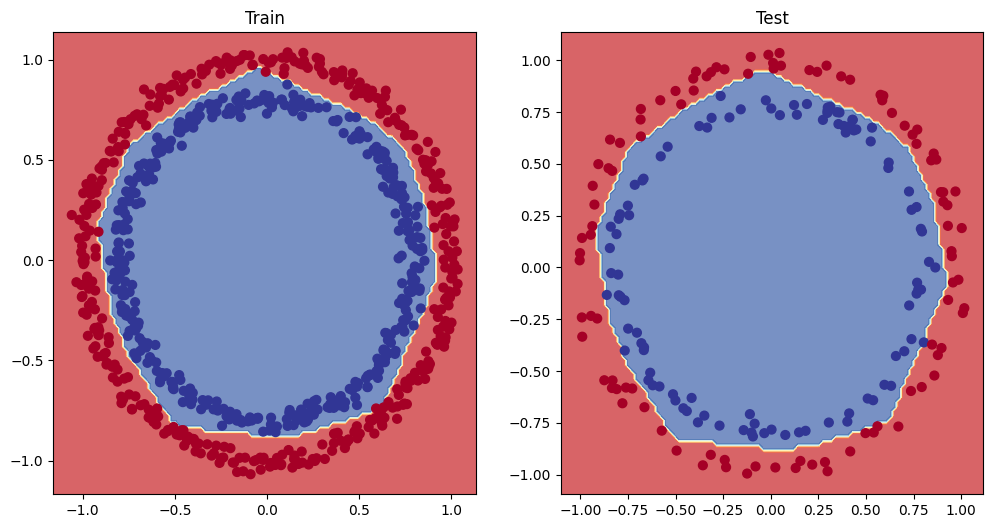

In [67]:
# Plot decision boundaries
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)